# Import Libraries

In [160]:
# Import Libraries

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer, label_binarize, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay, make_scorer, mean_squared_error,classification_report,confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc,roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import time

# Part 1: Data Preprocessing

In [161]:
# Load the Test Dataset - requires delimeter parameter (data is divided with semi-colons, not commas)
df_test = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/DS2_Assignments/refs/heads/main/test.csv', delimiter=';')

In [162]:
# Load the Train Dataset - requires delimeter parameter (data is divided with semi-colons, not commas)
df_train = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/DS2_Assignments/main/train.csv', delimiter=';')

In [163]:
# Merge both datasets together to maximize number of outcomes to work with - use concat (row-wise merge - columns are the same)
df = pd.concat([df_train, df_test], axis=0)

In [164]:
# Check the data
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


Check for Missing Values & Data Types

In [165]:
# Check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49732 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        49732 non-null  int64 
 1   job        49732 non-null  object
 2   marital    49732 non-null  object
 3   education  49732 non-null  object
 4   default    49732 non-null  object
 5   balance    49732 non-null  int64 
 6   housing    49732 non-null  object
 7   loan       49732 non-null  object
 8   contact    49732 non-null  object
 9   day        49732 non-null  int64 
 10  month      49732 non-null  object
 11  duration   49732 non-null  int64 
 12  campaign   49732 non-null  int64 
 13  pdays      49732 non-null  int64 
 14  previous   49732 non-null  int64 
 15  poutcome   49732 non-null  object
 16  y          49732 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.8+ MB


Exploring the Data (Basic Descriptive Statistics)

In [166]:
# Get basic statistical summary for numerical columns
print("Statistical Summary for Numerical Columns:\n", df.describe())

# For categorical columns, let's see the unique values
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Unique values in {col}:\n", df[col].value_counts())

Statistical Summary for Numerical Columns:
                 age        balance           day      duration      campaign  \
count  49732.000000   49732.000000  49732.000000  49732.000000  49732.000000   
mean      40.957472    1367.761562     15.816315    258.690179      2.766549   
std       10.615008    3041.608766      8.315680    257.743149      3.099075   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1431.000000     21.000000    320.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  49732.000000  49732.000000  
mean      40.158630      0.576892  
std      100.127123      2.254838  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000

In [167]:
# Convert 'y' column into binary values: 1 for 'yes' and 0 for 'no'
df['y'] = df['y'].map({'yes': 1, 'no': 0})

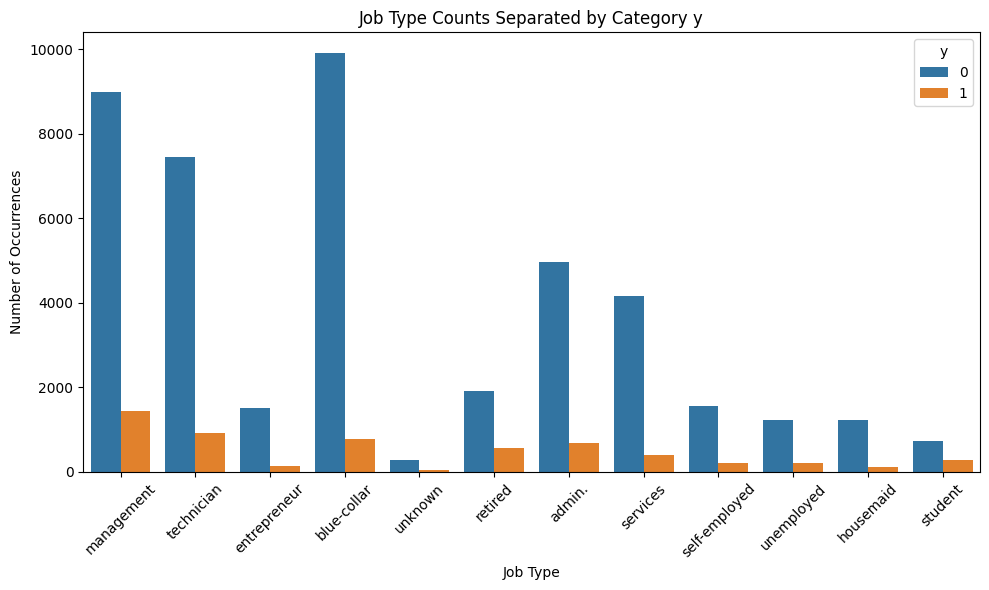

In [168]:
# Create a count plot with 'hue' for the 'y' column
plt.figure(figsize=(10,6))
sns.countplot(x='job', hue='y', data=df)

plt.title('Job Type Counts Separated by Category y')
plt.xlabel('Job Type')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

job
admin.           0.121968
blue-collar      0.072766
entrepreneur     0.083384
housemaid        0.090976
management       0.137336
retired          0.228549
self-employed    0.117480
services         0.089040
student          0.281800
technician       0.110341
unemployed       0.150245
unknown          0.125767
Name: y, dtype: float64


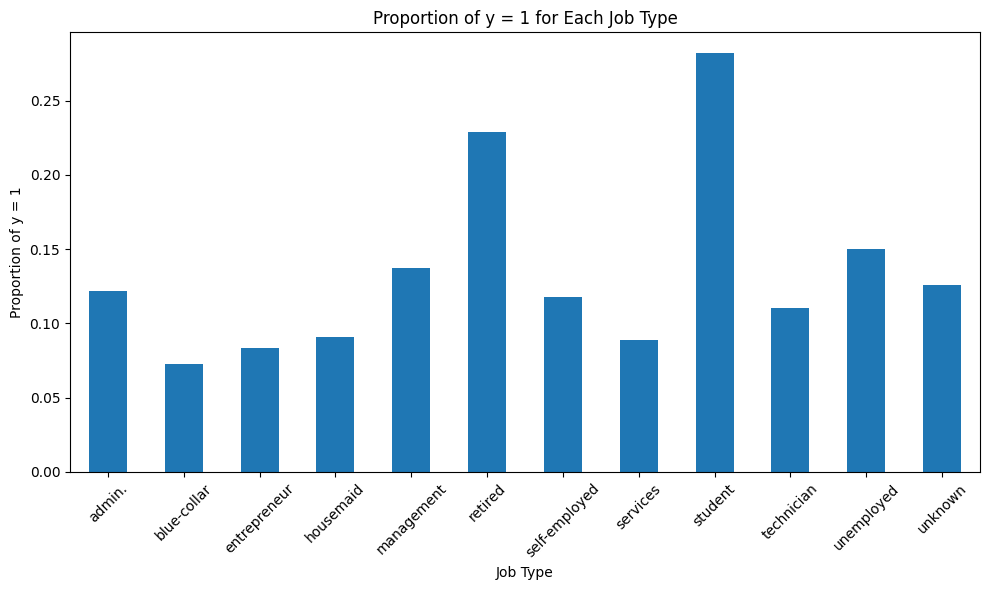

In [169]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('job')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Each Job Type')
plt.xlabel('Job Type')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

Possible positive relationship with Students and Retired

marital
divorced    0.121883
married     0.101030
single      0.148649
Name: y, dtype: float64


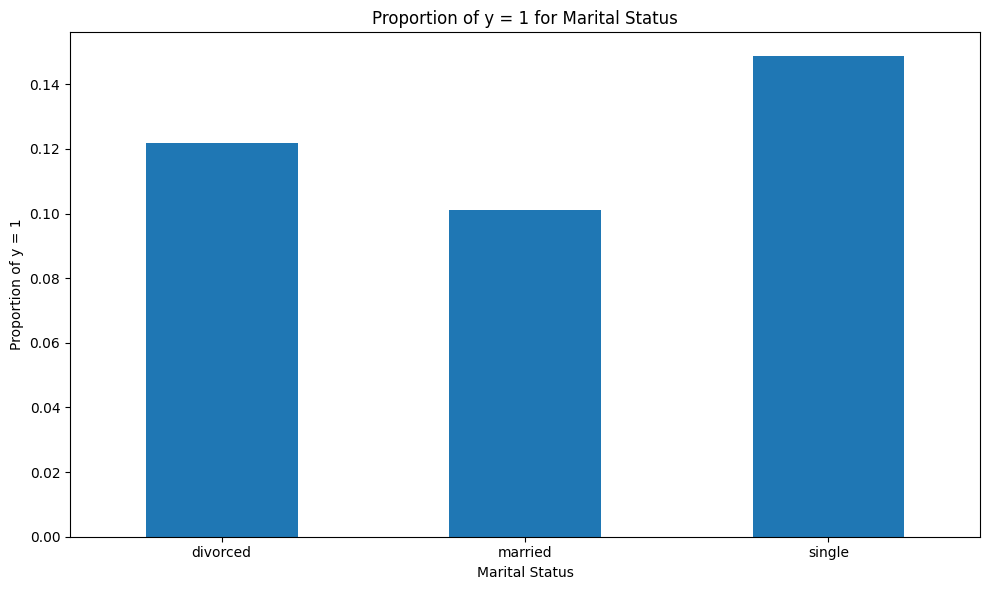

In [170]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('marital')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Possible Positive Relationship with those that are NOT married

education
primary      0.086997
secondary    0.105653
tertiary     0.149410
unknown      0.132583
Name: y, dtype: float64


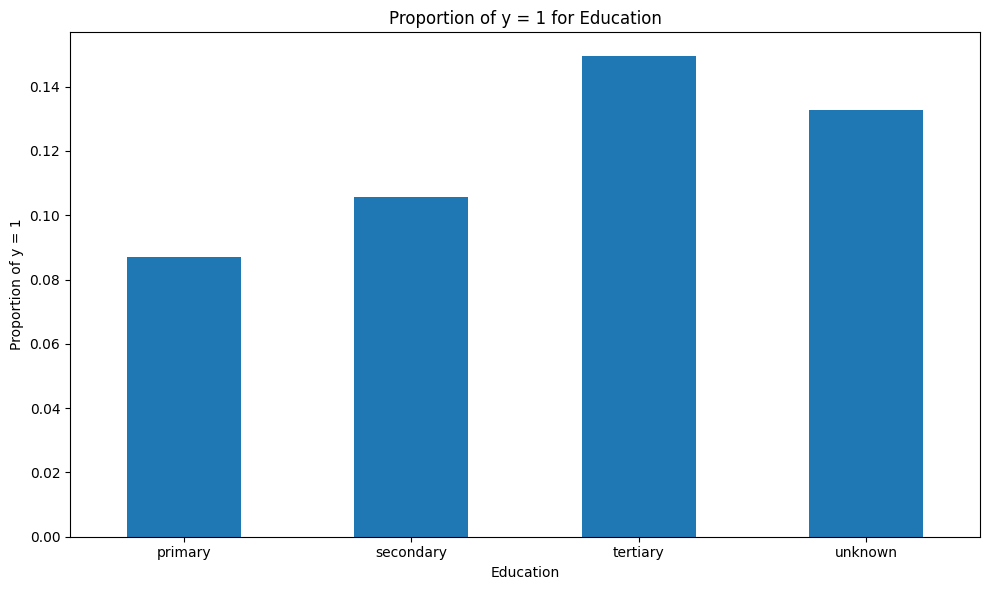

In [171]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('education')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Education')
plt.xlabel('Education')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Possible positive relationship to y for those with tertiary education and unknown

housing
no     0.165812
yes    0.077829
Name: y, dtype: float64


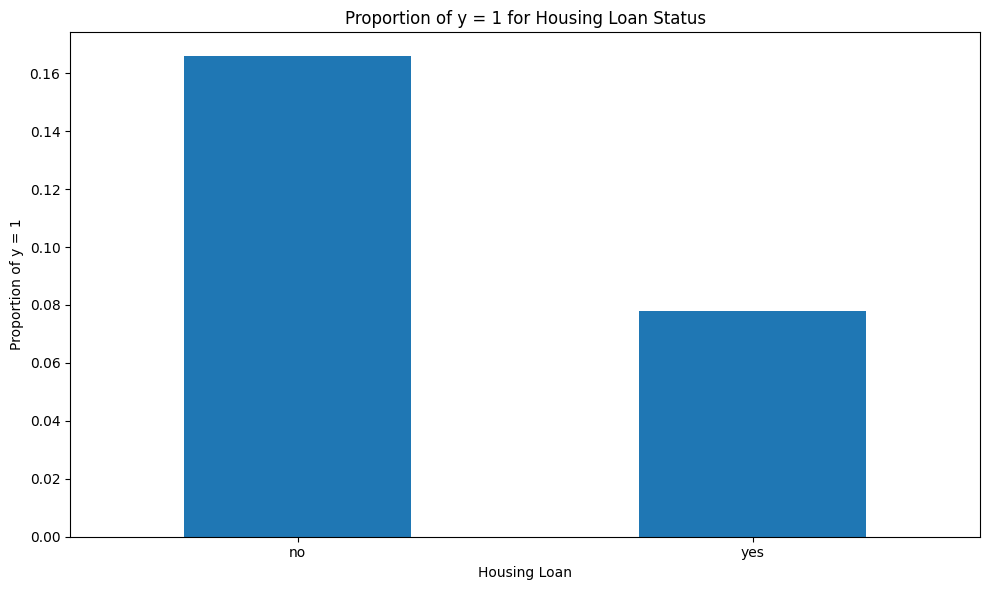

In [172]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('housing')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Housing Loan Status')
plt.xlabel('Housing Loan')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

The graph above shows that there's twice the liklihood of a successful customer when they do NOT have a housing Loan

loan
no     0.126397
yes    0.066415
Name: y, dtype: float64


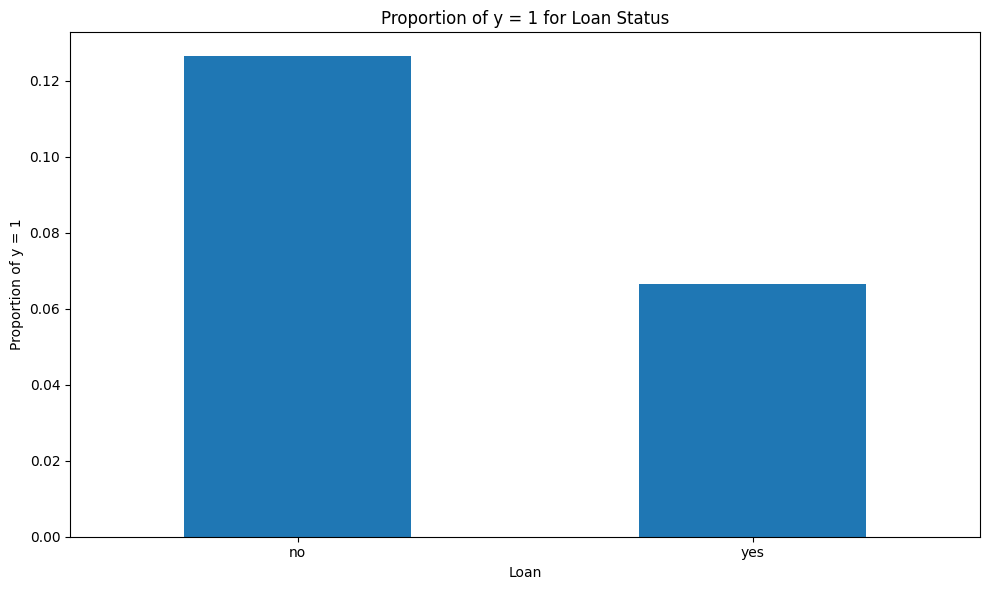

In [173]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('loan')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Loan Status')
plt.xlabel('Loan')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

The graph above shows a possible positive relationship to those who do NOT have a loan being more likely to say yes

default
no     0.117708
yes    0.068462
Name: y, dtype: float64


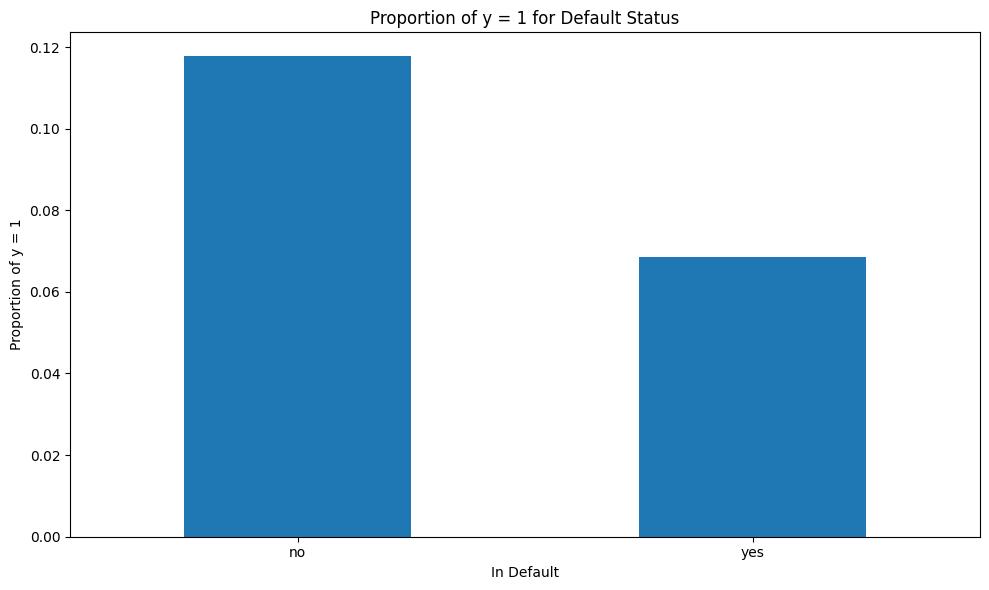

In [174]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('default')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Default Status')
plt.xlabel('In Default')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

The graph above showcases that those not in default are more likely to say yes

poutcome
failure    0.126322
other      0.169367
success    0.646951
unknown    0.091555
Name: y, dtype: float64


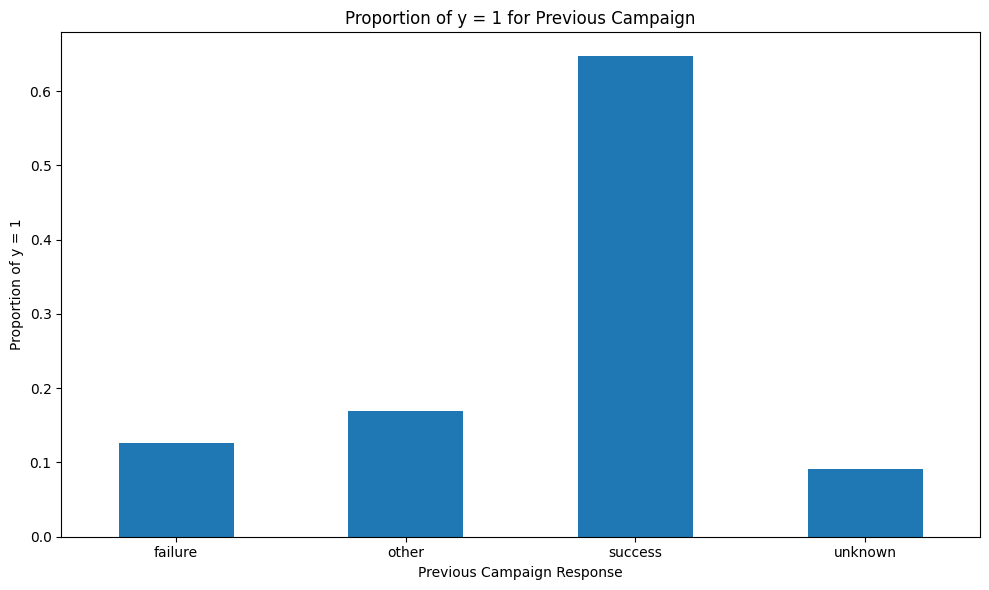

In [175]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('poutcome')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Previous Campaign')
plt.xlabel('Previous Campaign Response')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

The graph above showcases how previous Campaign Success leads to being more likely to have success this time as well - 64.7%

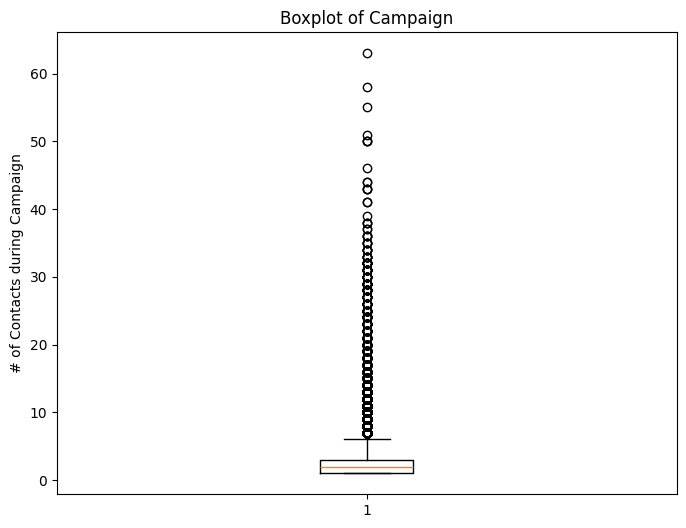

In [176]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['campaign'])
plt.title('Boxplot of Campaign')
plt.ylabel('# of Contacts during Campaign')
plt.show()

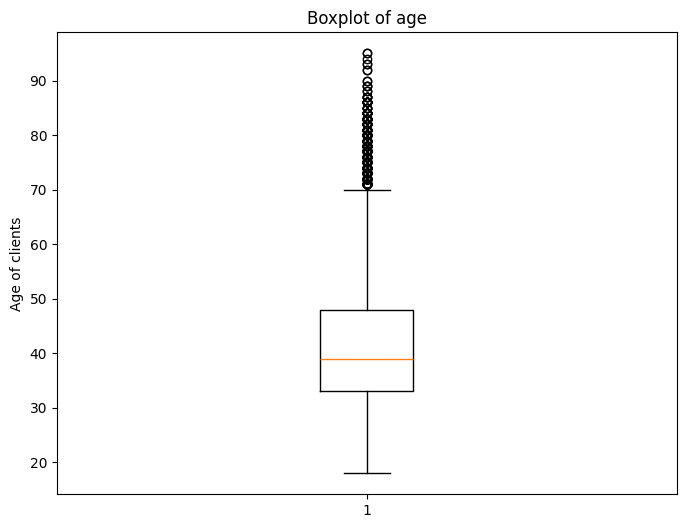

In [177]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['age'])
plt.title('Boxplot of age')
plt.ylabel('Age of clients')
plt.show()

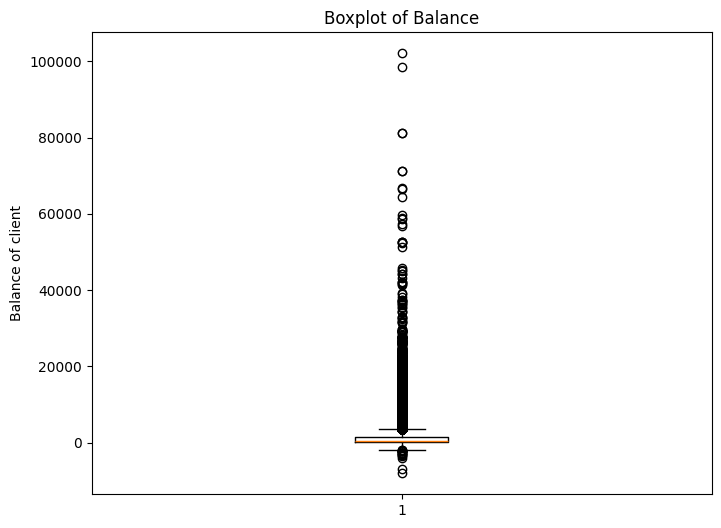

In [178]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['balance'])
plt.title('Boxplot of Balance')
plt.ylabel('Balance of client')
plt.show()

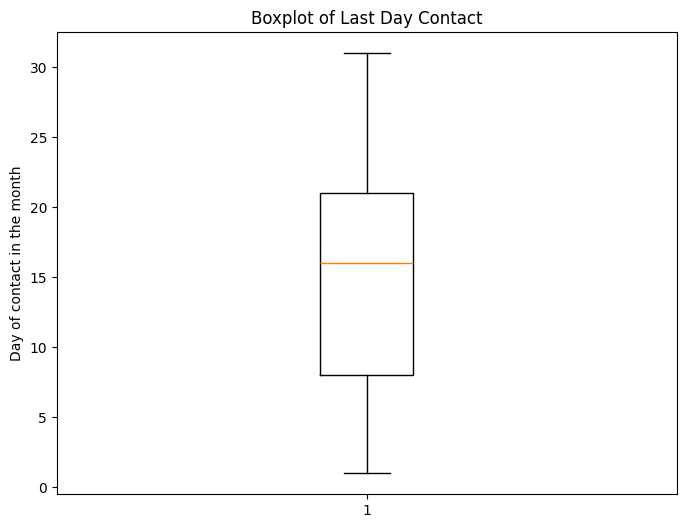

In [179]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['day'])
plt.title('Boxplot of Last Day Contact')
plt.ylabel('Day of contact in the month')
plt.show()

Handling Potential Outliers

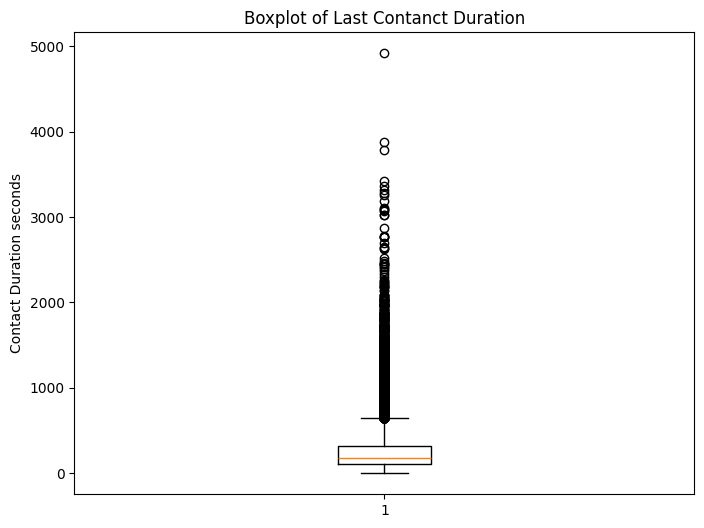

In [180]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['duration'])
plt.title('Boxplot of Last Contanct Duration')
plt.ylabel('Contact Duration seconds')
plt.show()

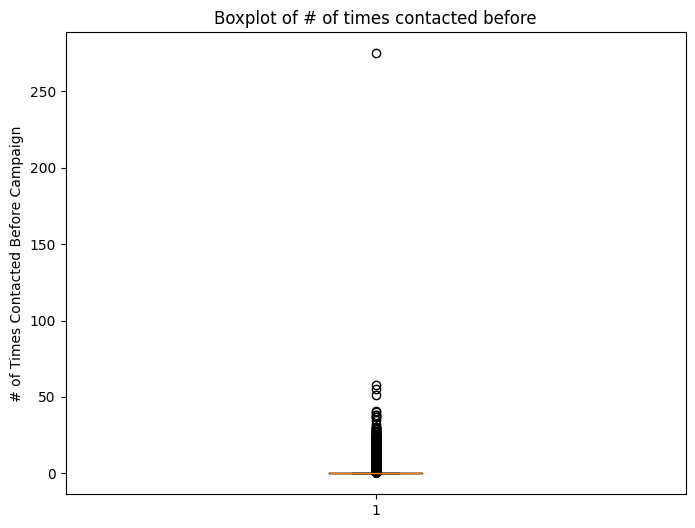

In [181]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['previous'])
plt.title('Boxplot of # of times contacted before')
plt.ylabel('# of Times Contacted Before Campaign')
plt.show()

In [182]:
df['previous'].max()

np.int64(275)

Day will be utilized as a categorical variable, while campaign, age, balance and duration will all be sorted in to bins. </br>
df['previous'] = 275 will be set to the 99th percentile as it is considered an extreme outlier. 


In [183]:
# Calculate the 99th percentile of the 'previous' column
percentile_99 = df['previous'].quantile(0.99)

# Set the rows where 'previous' equals 275 to the 99th percentile
df.loc[df['previous'] == 275, 'previous'] = percentile_99

In [184]:
df['age'].describe()

count    49732.000000
mean        40.957472
std         10.615008
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

In [185]:
# FEATURE ENGINEERING

# Define the age bins and labels
bins = [18, 30, 40, 50, float('inf')]
labels = ['18-29', '30-39', '40-49', '50+']

# Create the age bins and label them
df['age_bins'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df['age_bins'].value_counts()


age_bins
30-39    19897
40-49    12858
50+      11222
18-29     5755
Name: count, dtype: int64

age_bins
18-29    0.174109
30-39    0.105443
40-49    0.092238
50+      0.135805
Name: y, dtype: float64


C:\Users\zack\AppData\Local\Temp\ipykernel_44552\988866204.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby('age_bins')['y'].mean()


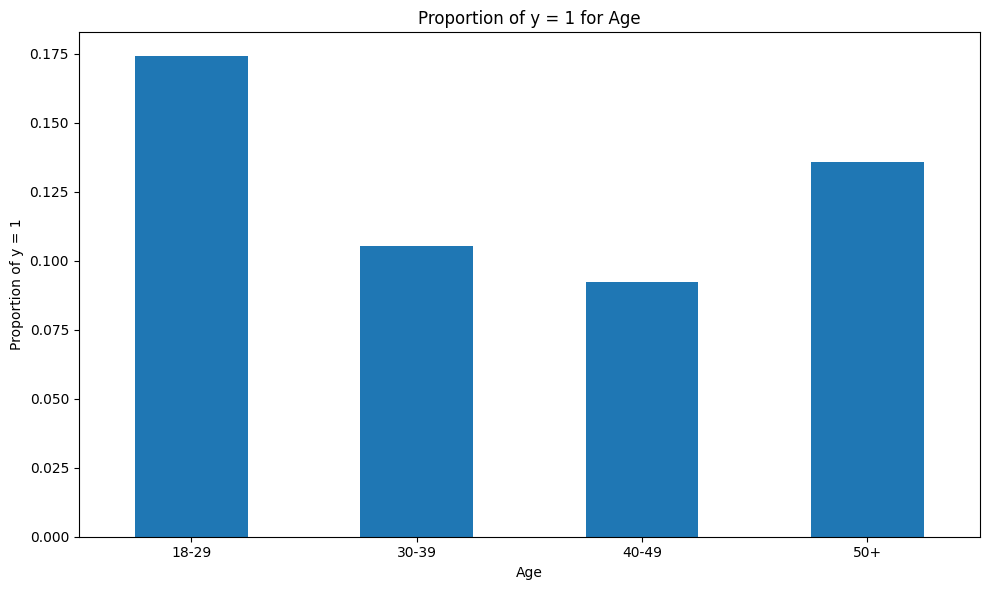

In [186]:
# Calculate the proportion of 'y = 1' for each age bin
proportions = df.groupby('age_bins')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Age')
plt.xlabel('Age')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [187]:
df['campaign'].describe()

count    49732.000000
mean         2.766549
std          3.099075
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [188]:
# Define the campaign bins and labels
bins = [1, 2, 3, 4, float('inf')]  
labels = ['1', '2', '3', '4+']  

# Apply the cut function
df['campaign_bins'] = pd.cut(df['campaign'], bins=bins, labels=labels, right=False)

# Check the results
df['campaign_bins'].value_counts()

campaign_bins
1     19278
2     13769
4+    10606
3      6079
Name: count, dtype: int64

campaign_bins
1     0.145295
2     0.111773
3     0.111038
4+    0.074958
Name: y, dtype: float64


C:\Users\zack\AppData\Local\Temp\ipykernel_44552\2183000875.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby('campaign_bins')['y'].mean()


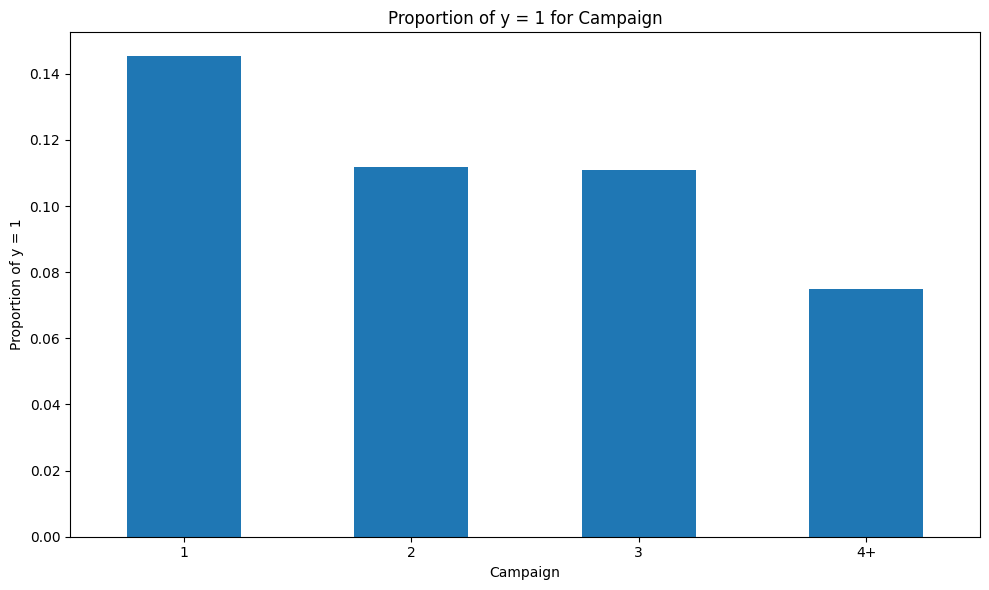

In [189]:
# Calculate the proportion of 'y = 1' for each campaign bin
proportions = df.groupby('campaign_bins')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Campaign')
plt.xlabel('Campaign')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [190]:
df['balance'].describe()

count     49732.000000
mean       1367.761562
std        3041.608766
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1431.000000
max      102127.000000
Name: balance, dtype: float64

In [191]:
# Define the balance bins and labels
bins = [float('-inf'), 50, 450, 1450, float('inf')]
labels = ['<50', '50-449', '450-1449', '1450+']

# Create the balance bins and label them
df['balance_bins'] = pd.cut(df['balance'], bins=bins, labels=labels, right=False)

df['balance_bins'].value_counts()

balance_bins
50-449      13523
450-1449    12518
1450+       12323
<50         11368
Name: count, dtype: int64

C:\Users\zack\AppData\Local\Temp\ipykernel_44552\2982822475.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby('balance_bins')['y'].mean()


balance_bins
<50         0.071165
50-449      0.106485
450-1449    0.126378
1450+       0.160594
Name: y, dtype: float64


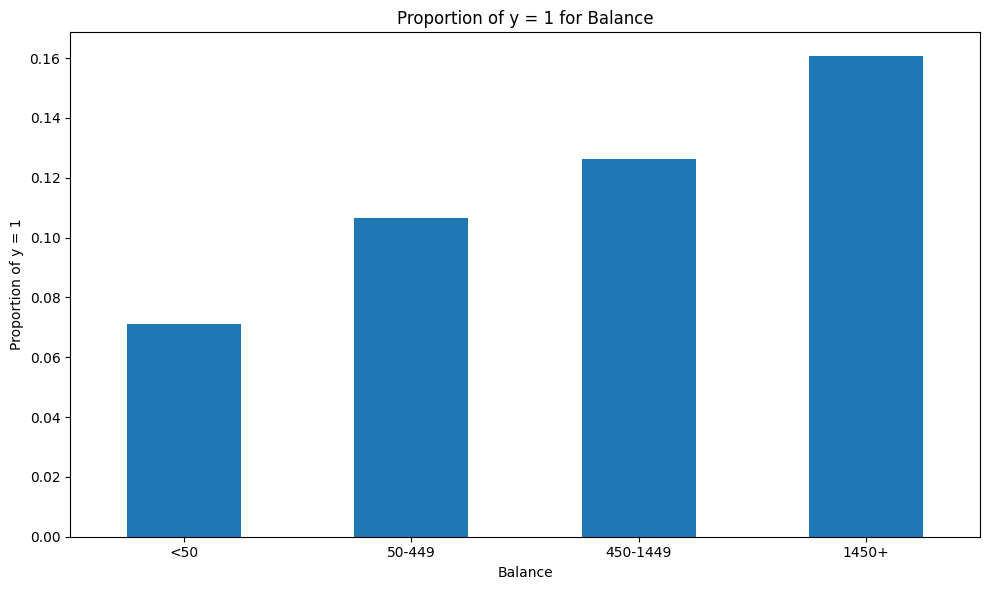

In [192]:
# Calculate the proportion of 'y = 1' for each balance bin
proportions = df.groupby('balance_bins')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Balance')
plt.xlabel('Balance')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [193]:
df['duration'].describe()

count    49732.000000
mean       258.690179
std        257.743149
min          0.000000
25%        103.000000
50%        180.000000
75%        320.000000
max       4918.000000
Name: duration, dtype: float64

In [194]:
# Define the duration bins and labels
bins = [0, 100, 180, 319, float('inf')]
labels = ['0-99', '100-179', '180-318', '319+']

# Create the duration bins and label them
df['duration_bins'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False)

df['duration_bins'].value_counts()

duration_bins
100-179    12958
319+       12497
180-318    12495
0-99       11782
Name: count, dtype: int64

C:\Users\zack\AppData\Local\Temp\ipykernel_44552\1563500916.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby('duration_bins')['y'].mean()


duration_bins
0-99       0.010779
100-179    0.048619
180-318    0.110844
319+       0.293510
Name: y, dtype: float64


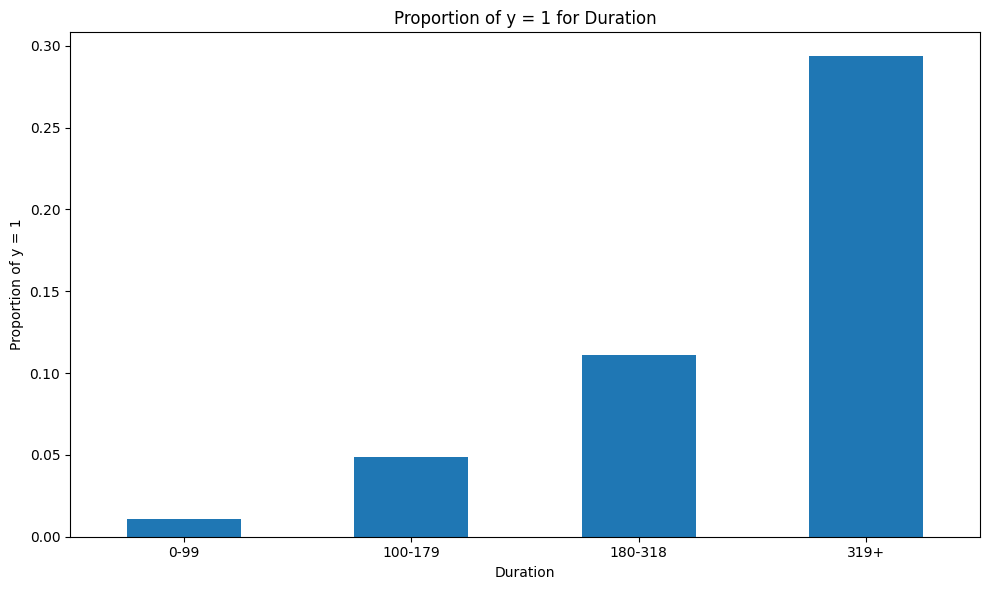

In [195]:
# Calculate the proportion of 'y = 1' for each duration bin
proportions = df.groupby('duration_bins')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Duration')
plt.xlabel('Duration')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [196]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'age_bins', 'campaign_bins',
       'balance_bins', 'duration_bins'],
      dtype='object')

# Findings Summary - Data Cleaning and Exploration

As a first step, we checked for missing or duplicated values in the dataset. Fortunately, there were no missing or duplicated values, simplifying the data cleaning process.

We began by exploring the dataset and obtaining a basic statistical summary. During this exploration, we focused on both categorical and numerical variables, particularly examining job types and their relationship with the target variable (y), which indicates whether a customer subscribed to a term deposit. We also calculated the proportions for each job type and visualized the number of positive responses (y = 1).

From these analyses, we generated several hypotheses regarding the relationships between the features and the target variable:  
<br>
**Key Observations:** (simpler language and consistent)
-	Job Type: We hypothesized a potential positive relationship between job type and subscription, particularly for students and retired individuals.
-	Marital Status: Unmarried individuals (specifically single and divorced) show a higher likelihood of term deposit subscription.
-	Education: Customers with tertiary education or unknown education status are more likely to subscribe.
-	Housing Loan: Customers without a housing loan are twice as likely to subscribe.
-	Personal Loan: A positive relationship exists between no personal loan and subscription.
-	Loan Default: Customers who are not in default are more likely to say yes.
-	Previous Campaigns: A successful outcome in a previous marketing campaign significantly increases the likelihood of a positive response in subsequent campaigns (64.7% likelihood of success).

**Visual Exploration of Categorical Variables:**

We used boxplots to visualize the spread of various numerical data, with the following findings:
-	Number of Contacts (Campaign): Most customers were contacted an average of 5 times during a campaign, with outliers reaching as many as 63 contacts.
-	Age Distribution: The majority of customers are between their mid-thirties and late forties, with outliers over 70 years old.
-	Account Balance: The average account balance is below 1,000, with some customers holding over 10,000.
-	Contact Day: Most customers were contacted between days 9 and 23 of the campaign, with a peak around day 16.
-	Call Duration: Calls typically lasted below 500 seconds, with a few lasting over 5,000 seconds.

**Preprocessing and Feature Engineering**

After cleaning and exploring the data, we moved on to feature engineering and preprocessing to prepare the data for modeling.

We observed that several numerical variables had skewed distributions, with outliers making it difficult to model effectively. To address this:

1.	Binning: For variables such as Age, Campaign (Number of Contacts), Balance, and Call Duration, we applied binning to group continuous values into discrete intervals. This helps reduce the influence of extreme outliers and makes relationships more interpretable.
2.	One-Hot Encoding: Categorical variables like job, education, and marital status were transformed using one-hot encoding to convert them into binary features.
3.	Scaling: Since some numeric features have varying ranges that could affect model performance, we employed StandardScaler to standardize these features. StandardScaler normalizes the numerical features by subtracting the mean and dividing by the standard deviation, ensuring all variables are on a comparable scale. This prevents features with larger values from disproportionately influencing model predictions. For example, account balance and call duration were scaled to have mean 0 and variance 1.

**Addressing Data Imbalance**

Our dataset is highly imbalanced, with a majority of customers not subscribing to a term deposit. This imbalance can skew model performance, particularly in favor of the majority class. To mitigate this, we structured our preprocessing pipeline to include strategies that help address this imbalance, such as resampling techniques or model adjustments (e.g., weighted classes).

**Pipelines for Preprocessing and Modeling**

To streamline the entire data transformation process and ensure reproducibility, we constructed a pipeline that integrates data preprocessing (including scaling, encoding, and binning) with model building. By using pipelines, we encapsulate each preprocessing step along with model training, ensuring that transformations such as scaling and encoding are applied consistently across all steps in model evaluation and cross-validation.


# Part 2.1: Baseline Models

In [197]:
# Let's proceed with the data preprocessing steps, including One Hot Encoding for categorical variables and scaling the numeric variables.

# Seperating the categorical and numeric columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome','age_bins', 'campaign_bins', 'balance_bins', 'duration_bins']
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# OneHotEncoding for categorical columns and StandardScaler for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In the original dataset, "Y" represents the response variable, indicating whether a client has subscribed to a term deposit.

Since term deposits are a significant source of revenue for banks, this target variable is critical for our model.

Now that we have completed the EDA and necessary data transformations, we will factor this information into the creation of our model and pipeline.


In [198]:
# Split the data into features and target
X = df.drop('y', axis=1)
y = df['y']

# Ensure stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [199]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,age_bins,campaign_bins,balance_bins,duration_bins
20031,46,technician,married,secondary,no,778,yes,no,cellular,8,aug,71,10,-1,0,unknown,40-49,4+,450-1449,0-99
19793,47,unemployed,married,secondary,no,1108,no,no,cellular,8,aug,169,2,-1,0,unknown,40-49,2,450-1449,100-179
21094,50,admin.,married,secondary,no,697,no,no,cellular,14,aug,118,4,-1,0,unknown,50+,4+,450-1449,100-179
34902,44,blue-collar,married,primary,no,0,yes,no,cellular,6,may,17,1,-1,0,unknown,40-49,1,<50,0-99
21503,37,management,married,tertiary,no,115,no,no,cellular,19,aug,78,2,-1,0,unknown,30-39,2,50-449,0-99


In [200]:
# Fit the pipeline to the training data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Display the processed features' shape
X_train_processed.shape, X_test_processed.shape

((39785, 67), (9947, 67))

In [201]:
# Here we check distribution of y value
y_balance = df['y'].value_counts()

# Display the balance of the classes
y_balance

y
0    43922
1     5810
Name: count, dtype: int64

As we can see from above the Y value is heavily imbalanced with more responses being negative (0) to the subscription than positive (1)

In [202]:
# Set up the logistic regression model
logreg = LogisticRegression(max_iter=1000)

In [203]:
# Define hyperparameters to tune
param_grid = {'C': [0.1, 1.0, 10.0], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}

# Perform grid search to find the best hyperparameters
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')

# Fit the model on the preprocessed training data
logreg_cv.fit(X_train_processed, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc')

In [204]:
# Check the distribution of 'y_train' 
print("y_train class distribution:", y_train.value_counts())

y_train class distribution: y
0    35137
1     4648
Name: count, dtype: int64


In [205]:
# Ensure stratified split to maintain class balance in both training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [206]:
# Check the overall distribution in the original target column 'y' again
print("Overall class distribution:", y.value_counts())

Overall class distribution: y
0    43922
1     5810
Name: count, dtype: int64


In [207]:
# Convert the 'y' column from 'yes'/'no' to binary values (1 for 'yes', 0 for 'no')
df['y'] = df['y']

# Verify the encoding was successful by checking the distribution again
y_encoded_distribution = df['y'].value_counts()

# Split the data into features and target
X = df.drop('y', axis=1)  # X includes all features except the target 'y'
y = df['y']  # y is the binary encoded target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the class distribution in y_train and y_test to ensure stratification worked
y_train_distribution = y_train.value_counts()
y_test_distribution = y_test.value_counts()

# Display the distributions for y_train and y_test
y_encoded_distribution, y_train_distribution, y_test_distribution


(y
 0    43922
 1     5810
 Name: count, dtype: int64,
 y
 0    35137
 1     4648
 Name: count, dtype: int64,
 y
 0    8785
 1    1162
 Name: count, dtype: int64)

The reason we stratify the dataset is because we want to ensure a proper proportion of 'yes' and 'no' values in the train and test sets, shown above.

In [208]:
# Fit and transform the training data, transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Display the shape of the processed training and test sets
X_train_processed.shape, X_test_processed.shape

((39785, 67), (9947, 67))

The training set now has 39,785 samples and 67 features after applying One Hot Encoding and scaling.
The test set has 9,947 samples and 67 features.

In [209]:
# Display the distribution of 'y' in the training set after preprocessing to confirm class balance
y_train_distribution = y_train.value_counts()

# Display the distribution of 'y' in the testing set to ensure it's consistent with the training set
y_test_distribution = y_test.value_counts()

# Output the class distribution in y_train and y_test
y_train_distribution, y_test_distribution

(y
 0    35137
 1     4648
 Name: count, dtype: int64,
 y
 0    8785
 1    1162
 Name: count, dtype: int64)

Now that our fixed and edited Pipeline has been created and our preprocessing steps have been added to it we can go on to make our own baseline models.

In [210]:
# Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test_processed)

# Evaluate Logistic Regression model
logreg_report = classification_report(y_test, y_pred_logreg)

In [211]:
# k-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_processed)

# Evaluate k-NN model
knn_report = classification_report(y_test, y_pred_knn)

In [212]:
print(logreg_report)
print(knn_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      8785
           1       0.65      0.34      0.45      1162

    accuracy                           0.90      9947
   macro avg       0.79      0.66      0.70      9947
weighted avg       0.89      0.90      0.89      9947

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      8785
           1       0.60      0.36      0.45      1162

    accuracy                           0.90      9947
   macro avg       0.76      0.67      0.70      9947
weighted avg       0.88      0.90      0.89      9947



Logistic Regression:
Precision (Class 0): 92%
Recall (Class 0): 97%
F1-Score (Class 0): 95%
Precision (Class 1): 64%
Recall (Class 1): 35%
F1-Score (Class 1): 45%
Accuracy: 90%
k-NN:
Precision (Class 0): 92%
Recall (Class 0): 97%
F1-Score (Class 0): 94%
Precision (Class 1): 60%
Recall (Class 1): 34%
F1-Score (Class 1): 43%
Accuracy: 90%

Both models perform similarly, with high accuracy but lower recall for class 1 (the positive class). This suggests that while the models are good at predicting the majority class (0), they struggle with identifying the minority class (1), which is typical for imbalanced datasets.

In [213]:
# Logistic Regression: Define the parameter grid for tuning
logreg_param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['lbfgs', 'liblinear']  # Different solvers for optimization
}

# Set up the GridSearchCV for Logistic Regression
logreg_cv = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), logreg_param_grid, cv=5, scoring='roc_auc')
logreg_cv.fit(X_train_processed, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc')

In [214]:
# Predict using the best Logistic Regression model
y_pred_logreg_tuned = logreg_cv.predict(X_test_processed)

In [215]:
# k-NN: Define the parameter grid for tuning
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'metric': ['euclidean', 'manhattan']  # Different distance metrics
}

# Set up the GridSearchCV for k-NN
knn_cv = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X_train_processed, y_train)

# Predict using the best k-NN model
y_pred_knn_tuned = knn_cv.predict(X_test_processed)

In [216]:
# Evaluate both tuned models
logreg_tuned_report = classification_report(y_test, y_pred_logreg_tuned)
knn_tuned_report = classification_report(y_test, y_pred_knn_tuned)

In [217]:
# Now we display the results of the 2 models with Logistic regression on top and KNN on bottom as well as the best parameters used for them
print(logreg_tuned_report)
print(knn_tuned_report)

print(logreg_cv.best_params_)
print(knn_cv.best_params_)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      8785
           1       0.65      0.34      0.45      1162

    accuracy                           0.90      9947
   macro avg       0.78      0.66      0.70      9947
weighted avg       0.89      0.90      0.89      9947

              precision    recall  f1-score   support

           0       0.92      0.98      0.94      8785
           1       0.63      0.32      0.42      1162

    accuracy                           0.90      9947
   macro avg       0.77      0.65      0.68      9947
weighted avg       0.88      0.90      0.88      9947

{'C': 0.1, 'solver': 'liblinear'}
{'metric': 'euclidean', 'n_neighbors': 9}


Results from tuning both the Logistic Regression and k-NN models are as displayed above.


**Observations:**

Logistic Regression slightly outperforms k-NN in terms of both precision and recall for the minority class (1). However, both models show low recall for class 1, indicating that while the models are good at identifying class 0, they struggle to identify the minority class (1).
k-NN performs similarly to Logistic Regression but with lower recall for class 1.

Compared to the previous models before the hyper parameter tuning the models appear to perform slightly better in their recall and precision but the improvement is not very significant.

In the current analysis, we tuned Logistic Regression and k-NN models for an imbalanced dataset. Unfortunately, both models struggled to properly handle the imbalance, as reflected in the poor recall scores for the minority class, which indicate that they failed to capture many of the true positive cases.

**Performance on Imbalanced Data**

**Logistic Regression:**

The tuned Logistic Regression model, with C=0.1 and solver='lbfgs', achieved decent precision for the minority class (0.65), but the recall was dismally low (0.34). This suggests that while the model is good at avoiding false positives, it fails to identify a large portion of the true positive cases from the minority class. In scenarios where false negatives are costly, such as fraud detection or medical diagnoses, this model is clearly inadequate.

**k-NN:**

For k-NN, we tuned the n_neighbors parameter and the metric for distance calculation. The best configuration used 9 neighbors and the Euclidean distance metric. Unfortunately, similar to Logistic Regression, k-NN had low recall (0.32) and only marginally acceptable precision (0.63). As a lazy learner, k-NN typically struggles with highly imbalanced data because it treats all neighbors equally, making it more sensitive to the overrepresented majority class.

**Why These Models Struggle:**

Both Logistic Regression and k-NN are fundamentally limited when dealing with imbalanced datasets. They naturally gravitate towards predicting the majority class more frequently, as evidenced by the high precision and recall scores for the majority class (class 0). These results reflect an inherent bias, which skews the evaluation metrics and creates a false sense of strong model performance if we focus solely on accuracy.

In [218]:
# Retrieve the feature names for the categorical columns from OneHotEncoder
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)

# Combine both the numeric feature names and the encoded categorical feature names
all_feature_names = numeric_cols + list(cat_feature_names)

# Get the coefficients from the best Logistic Regression model
best_logreg_model = logreg_cv.best_estimator_
logreg_coefficients = best_logreg_model.coef_

# Create a DataFrame to display the feature names alongside their coefficients
coefficients_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': logreg_coefficients[0]})

# Sort by the absolute value of the coefficient to highlight important features
coefficients_df['Absolute Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df_sorted = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)


# Adjust pandas settings to prevent output truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No column width restrictions
pd.set_option('display.max_colwidth', None)  # No truncation of column content

print(coefficients_df_sorted)

                  Feature  Coefficient  Absolute Coefficient
49       poutcome_success     1.443824              1.443824
42              month_mar     1.341095              1.341095
63     duration_bins_0-99    -1.290520              1.290520
39              month_jan    -1.137085              1.137085
34        contact_unknown    -1.029594              1.029594
40              month_jul    -0.814910              0.814910
66     duration_bins_319+     0.802556              0.802556
44              month_nov    -0.796061              0.796061
45              month_oct     0.774879              0.774879
3                duration     0.743561              0.743561
50       poutcome_unknown    -0.731118              0.731118
47       poutcome_failure    -0.730884              0.730884
46              month_sep     0.679436              0.679436
36              month_aug    -0.580041              0.580041
29            housing_yes    -0.533777              0.533777
43              month_ma

Checking the above coefficients of the LogisticRegression, allows us to see what is driving the model, and thus possibly remove features that are unnecessary.

This also shows that the features we made are making a difference! They are actually driving the model, even for the weak features that do not drive the model when not binned.

 - pdays, balance, previous, campaign, day (Can all be removed as they are less than 0.1 weight in the coefficients)
- we can't remove OHE Features that have certain observations that aren't helping, only standalone features

In [219]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'age_bins', 'campaign_bins',
       'balance_bins', 'duration_bins'],
      dtype='object')

In [220]:
# Ensure stratified split to maintain class balance in both training and test sets
X = df[['age', 'duration', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome','age_bins', 'campaign_bins', 'balance_bins', 'duration_bins']]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify categorical and numeric columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome','age_bins', 'campaign_bins', 'balance_bins', 'duration_bins']
numeric_cols = ['age', 'duration']

# Build a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),   # Scaling for numeric columns
        ('cat', OneHotEncoder(), categorical_cols) # One Hot Encoding for categorical columns
    ])

# Fit and transform the training data, transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Display the shape of the processed training and test sets
X_train_processed.shape, X_test_processed.shape

((39785, 62), (9947, 62))

In [221]:
# Logistic Regression pipeline
logreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

# k-NN pipeline
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])

# Step 3: Define parameter grids for both models
logreg_param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['lbfgs', 'liblinear']  # Solvers for optimization
}

knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'classifier__metric': ['euclidean', 'manhattan']  # Distance metrics
}

# Step 4: Set up GridSearchCV for both models
logreg_cv = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring='roc_auc')
knn_cv = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='roc_auc')

# Step 5: Fit both models
logreg_cv.fit(X_train, y_train)
knn_cv.fit(X_train, y_train)

# Step 6: Predict and print classification report for Logistic Regression
y_pred_logreg = logreg_cv.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Step 7: Predict and print classification report for k-NN
y_pred_knn = knn_cv.predict(X_test)
print("k-NN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Print the best parameters for Logistic Regression
print("Best Parameters for Logistic Regression:")
print(logreg_cv.best_params_)

# Print the best parameters for k-NN
print("Best Parameters for k-NN:")
print(knn_cv.best_params_)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      8785
           1       0.65      0.33      0.44      1162

    accuracy                           0.90      9947
   macro avg       0.78      0.65      0.69      9947
weighted avg       0.89      0.90      0.89      9947

k-NN Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      8785
           1       0.59      0.29      0.39      1162

    accuracy                           0.89      9947
   macro avg       0.75      0.63      0.67      9947
weighted avg       0.87      0.89      0.88      9947

Best Parameters for Logistic Regression:
{'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best Parameters for k-NN:
{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9}


# Part 2.2 - Implement and Tune SMOTE to improve Baseline Models for the imbalanced dataset

In [222]:
# Lets also use the Imbalanced Pipeline (needed to use oversampling techniques))

# Logistic Regression pipeline with SMOTE
logreg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('smote', SMOTE(random_state=42)),  # SMOTE step
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# k-NN pipeline with SMOTE
knn_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # SMOTE step
    ('classifier', KNeighborsClassifier())
])

# Define parameter grids for both models
logreg_param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['lbfgs', 'liblinear']  # Solvers for optimization
}

knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'classifier__metric': ['euclidean', 'manhattan'],  # Distance metrics
    'classifier__weights': ['uniform', 'distance']  # Uniform vs. distance-based weighting
}

# Set up GridSearchCV for both models
logreg_cv = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring='roc_auc')
knn_cv = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='roc_auc')

# Fit both models
logreg_cv.fit(X_train, y_train)
knn_cv.fit(X_train, y_train)

# Predict and print classification report for Logistic Regression
y_pred_logreg = logreg_cv.predict(X_test)
print("Logistic Regression Classification Report with SMOTE:")
print(classification_report(y_test, y_pred_logreg))

# Predict and print classification report for k-NN
y_pred_knn = knn_cv.predict(X_test)
print("k-NN Classification Report with SMOTE:")
print(classification_report(y_test, y_pred_knn))

# Print the best parameters for Logistic Regression
print("Best Parameters for Logistic Regression:")
print(logreg_cv.best_params_)

# Print the best parameters for k-NN
print("Best Parameters for k-NN:")
print(knn_cv.best_params_)

Logistic Regression Classification Report with SMOTE:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      8785
           1       0.41      0.82      0.54      1162

    accuracy                           0.84      9947
   macro avg       0.69      0.83      0.72      9947
weighted avg       0.91      0.84      0.86      9947

k-NN Classification Report with SMOTE:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      8785
           1       0.39      0.85      0.53      1162

    accuracy                           0.83      9947
   macro avg       0.68      0.84      0.71      9947
weighted avg       0.91      0.83      0.85      9947

Best Parameters for Logistic Regression:
{'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best Parameters for k-NN:
{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}


In [223]:
# Lets focus on the Logisitic Regression for now, and try tuning the SMOTE parameters to perform better by adding a GridSearch

# Logistic Regression pipeline with SMOTE
logreg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('smote', SMOTE(random_state=42)),  # SMOTE step
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Define parameter grid for Logistic Regression and SMOTE
logreg_param_grid = {
    'smote__sampling_strategy': [0.5, 0.75, 1.0],  # Oversample the minority class to 50%, 75%, or 100% of the majority class
    'smote__k_neighbors': [3, 5],  # Number of neighbors for SMOTE
    'classifier__C': [0.1, 1, 10],  # Regularization strength for Logistic Regression
    'classifier__solver': ['lbfgs', 'liblinear']  # Solvers for Logistic Regression
}

# Set up GridSearchCV for Logistic Regression pipeline with SMOTE
logreg_cv = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring='roc_auc')

# Fit the model
logreg_cv.fit(X_train, y_train)

# Predict using the best model found by GridSearchCV
y_pred_logreg = logreg_cv.predict(X_test)

# Print the best parameters
print("Best Parameters for Logistic Regression with SMOTE:")
print(logreg_cv.best_params_)

# Print classification report
print("\nLogistic Regression Classification Report with SMOTE:")
print(classification_report(y_test, y_pred_logreg))

c:\Users\zack\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for Logistic Regression with SMOTE:
{'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'smote__k_neighbors': 3, 'smote__sampling_strategy': 1.0}

Logistic Regression Classification Report with SMOTE:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      8785
           1       0.41      0.82      0.54      1162

    accuracy                           0.84      9947
   macro avg       0.69      0.83      0.72      9947
weighted avg       0.91      0.84      0.86      9947



Final LogisticRegression with Timer for comparison

In [224]:
# Best parameters from GridSearchCV
best_params_logreg = {
    'smote__sampling_strategy': 1.0,  # SMOTE oversamples the minority class to 100% of the majority class
    'smote__k_neighbors': 5,          # Number of neighbors for SMOTE
    'classifier__C': 0.1,             # Regularization strength for Logistic Regression
    'classifier__solver': 'liblinear'  # Solver for Logistic Regression
}

# Step 1: Define the preprocessor (if already defined, reuse it)
# Example: preprocessor = ColumnTransformer([...])

# Step 2: Create a pipeline with preprocessor, SMOTE, and Logistic Regression using the best parameters
logreg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Add the preprocessor step if applicable
    ('smote', SMOTE(sampling_strategy=best_params_logreg['smote__sampling_strategy'],
                    k_neighbors=best_params_logreg['smote__k_neighbors'], random_state=42)),
    ('classifier', LogisticRegression(C=best_params_logreg['classifier__C'],
                                      solver=best_params_logreg['classifier__solver'],
                                      max_iter=1000, random_state=42))
])

# Step 3: Train the model with SMOTE
logreg_pipeline.fit(X_train, y_train)

# Step 4: Start timing the prediction process
start_time = time.time()

# Step 5: Make predictions using the trained model
y_pred_logreg = logreg_pipeline.predict(X_test)

# Step 6: End timing and calculate elapsed time for prediction
end_time = time.time()
elapsed_time = end_time - start_time

# Step 7: Print how long the prediction took
print(f"Logistic Regression with SMOTE prediction took {elapsed_time:.4f} seconds.")

# Step 8: Print the classification report for the predictions
logreg_report = classification_report(y_test, y_pred_logreg)
print("Logistic Regression Classification Report (with SMOTE):")
print(logreg_report)

Logistic Regression with SMOTE prediction took 0.0175 seconds.
Logistic Regression Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      8785
           1       0.41      0.82      0.54      1162

    accuracy                           0.84      9947
   macro avg       0.69      0.83      0.72      9947
weighted avg       0.91      0.84      0.86      9947



Hypertuning the SMOTE Parameters resulted in little to no change in performance of the Logistic Regression, so we chose to end our tuning here.

KNN Model Final Tuning with SMOTE

In [225]:
# Define the preprocessor (assuming numeric_cols and categorical_cols are predefined)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),  # Scaling numeric columns
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encoding categorical columns
    ]
)

# k-NN pipeline with SMOTE
knn_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),   # Preprocessing step
    ('smote', SMOTE(random_state=42)),  # SMOTE step for oversampling
    ('classifier', KNeighborsClassifier())  # k-NN classifier
])

# Define parameter grid for SMOTE and k-NN
knn_param_grid = {
    # SMOTE parameters
    'smote__sampling_strategy': [0.5, 1.0],  # Different resampling strategies (0.5: balance minority to half the majority)
    'smote__k_neighbors': [3, 5],  # k_neighbors for SMOTE (number of nearest neighbors used to synthesize new samples)

    # k-NN classifier parameters
    'classifier__n_neighbors': [3, 7, 9],  # Number of neighbors
    'classifier__metric': ['euclidean'],  # Distance metrics
    'classifier__weights': ['uniform', 'distance']  # Uniform vs. distance-based weighting
}

# Set up GridSearchCV for k-NN with SMOTE
knn_cv = GridSearchCV(estimator=knn_pipeline, 
                      param_grid=knn_param_grid, 
                      cv=3,  # 3-fold cross-validation
                      scoring='roc_auc',  # Optimizing for AUC-ROC
                      verbose=2)  # Verbose output for progress tracking

# Fit the model
knn_cv.fit(X_train, y_train)

# Make predictions using the best found model
y_pred_knn = knn_cv.predict(X_test)

# Print classification report for k-NN
print("k-NN Classification Report with SMOTE and GridSearch:")
print(classification_report(y_test, y_pred_knn))

# Print the best parameters found by GridSearchCV for k-NN
print("Best Parameters for k-NN with SMOTE:")
print(knn_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform, smote__k_neighbors=3, smote__sampling_strategy=0.5; total time=   9.6s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform, smote__k_neighbors=3, smote__sampling_strategy=0.5; total time=   9.5s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform, smote__k_neighbors=3, smote__sampling_strategy=0.5; total time=   9.4s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform, smote__k_neighbors=3, smote__sampling_strategy=1.0; total time=  12.9s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform, smote__k_neighbors=3, smote__sampling_strategy=1.0; total time=  13.1s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform, smote__k_neigh

Final KNN Model and Timer with SMOTE

In [226]:
# Retrieve the best parameters for SMOTE and k-NN from the GridSearchCV
best_params = knn_cv.best_params_

# Update the pipeline with the best parameters found
knn_pipeline_best = ImbPipeline(steps=[
    ('preprocessor', preprocessor),   # Preprocessing step
    ('smote', SMOTE(sampling_strategy=best_params['smote__sampling_strategy'], 
                    k_neighbors=best_params['smote__k_neighbors'], random_state=42)),  # SMOTE step with best params
    ('classifier', KNeighborsClassifier(n_neighbors=best_params['classifier__n_neighbors'],
                                        metric=best_params['classifier__metric'],
                                        weights=best_params['classifier__weights']))  # k-NN with best params
])

# Fit the final model using the entire training set
knn_pipeline_best.fit(X_train, y_train)

# Start timing the prediction process
start_time = time.time()

# Make predictions on the test set
y_pred_final_knn = knn_pipeline_best.predict(X_test)

# End timing and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print the time it took to predict
print(f"Final k-NN model took {elapsed_time:.2f} seconds to make predictions.")

# Print classification report for the final k-NN model
print("Final k-NN Classification Report with SMOTE (on the full test set):")
print(classification_report(y_test, y_pred_final_knn))

Final k-NN model took 10.51 seconds to make predictions.
Final k-NN Classification Report with SMOTE (on the full test set):
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      8785
           1       0.44      0.77      0.56      1162

    accuracy                           0.86      9947
   macro avg       0.71      0.82      0.74      9947
weighted avg       0.91      0.86      0.88      9947



# Part 3: Ensemble Models

In [227]:
# Random Forest Model with manual inputs for certain parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [228]:
# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test_processed)

rf_report = classification_report(y_test, y_pred_rf)
print(rf_report)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      8785
           1       0.69      0.41      0.51      1162

    accuracy                           0.91      9947
   macro avg       0.81      0.69      0.73      9947
weighted avg       0.90      0.91      0.90      9947



Precision (Class 0): 93% – The proportion of correctly identified negatives (Class 0) out of all predicted negatives.

Recall (Class 0): 98% – The proportion of actual negatives (Class 0) correctly identified.

Precision (Class 1): 69% – The proportion of correctly identified positives (Class 1) out of all predicted positives.

Recall (Class 1): 41% – The proportion of actual positives (Class 1) correctly identified.

Accuracy: 91% – The overall proportion of correctly classified instances.

Macro Average: Averaged precision, recall, and F1-score across both classes.

Weighted Average: Averages weighted by the number of instances in each class.

Summary:
The Random Forest model performs well for class 0 but struggles with class 1 due to the class imbalance.
The recall for class 1 is lower, meaning the model is missing a significant portion of positive instances.

Basically this model is also not that good because of the data imbalance

Tune Random Forest and Apply Class_Weight = Balanced for imbalanced dataset handling

In [229]:
# Define a reduced parameter grid for the Random Forest with class_weight
param_grid_rf = {
    'classifier__n_estimators': [100, 200],   # Fewer options for number of trees
    'classifier__max_depth': [10, 20],        # Reduced options for max depth
    'classifier__min_samples_split': [2, 5],  # Reduced options for min samples split
    'classifier__min_samples_leaf': [1, 2],   # Reduced options for min samples leaf
    'classifier__bootstrap': [True]           # Only test bootstrapping, remove False
}

# Initialize the RandomForestClassifier with class_weight='balanced'
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Combine RandomForestClassifier into a pipeline (no SMOTE needed)
model_pipeline_rf = Pipeline(steps=[
    ('classifier', rf_model)  # Random Forest classifier step
])

# Set up GridSearchCV with the pipeline and the parameter grid
rf_grid_search = GridSearchCV(estimator=model_pipeline_rf, 
                              param_grid=param_grid_rf, 
                              cv=3,  # Reduced cross-validation folds to 3 for faster processing
                              scoring='roc_auc',  # Metric to optimize
                              verbose=3)  # Increased verbosity level to track progress in detail

# Start tracking the time
start_time = time.time()

# Fit the model with GridSearchCV
rf_grid_search.fit(X_train_processed, y_train)

# Calculate total run time
end_time = time.time()
elapsed_time = end_time - start_time

# Print how long the grid search took
print(f"GridSearchCV took {elapsed_time:.2f} seconds to complete.")

# Make predictions using the best found model
y_pred_rf = rf_grid_search.best_estimator_.predict(X_test_processed)

# Print the classification report
rf_report = classification_report(y_test, y_pred_rf)
print("Random Forest Classification Report (with class_weight='balanced' and GridSearch):")
print(rf_report)

# Print the best parameters found by GridSearchCV
print("Best Parameters for Random Forest with class_weight='balanced':")
print(rf_grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END classifier__bootstrap=True, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.911 total time=   3.3s
[CV 2/3] END classifier__bootstrap=True, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.913 total time=   3.4s
[CV 3/3] END classifier__bootstrap=True, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.904 total time=   3.5s
[CV 1/3] END classifier__bootstrap=True, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.912 total time=   6.9s
[CV 2/3] END classifier__bootstrap=True, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200;, 

Final Random Forest Model with Timer predicting on Dataset

In [230]:
# Retrieve the best parameters from the grid search
best_params = rf_grid_search.best_params_

# Initialize the RandomForestClassifier with class_weight='balanced' and best parameters
rf_final_model = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced', 
    n_estimators=best_params['classifier__n_estimators'],
    max_depth=best_params['classifier__max_depth'],
    min_samples_split=best_params['classifier__min_samples_split'],
    min_samples_leaf=best_params['classifier__min_samples_leaf'],
    bootstrap=best_params['classifier__bootstrap']
)

# Combine the final RandomForestClassifier into a pipeline (no SMOTE needed)
final_pipeline_rf = Pipeline(steps=[
    ('classifier', rf_final_model)  # Random Forest classifier step
])

# Fit the final model on the training data
final_pipeline_rf.fit(X_train_processed, y_train)

# Start tracking the time to predict on the test set
start_time = time.time()

# Make predictions using the final model on the test data
y_pred_final_rf = final_pipeline_rf.predict(X_test_processed)

# Stop tracking the time after predictions
end_time = time.time()
elapsed_time_prediction = end_time - start_time

# Print how long the prediction took
print(f"Prediction on the test data took {elapsed_time_prediction:.2f} seconds.")

# Print the classification report for the final model
final_rf_report = classification_report(y_test, y_pred_final_rf)
print("Final Random Forest Classification Report (with class_weight='balanced'):")
print(final_rf_report)

Prediction on the test data took 0.20 seconds.
Final Random Forest Classification Report (with class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      8785
           1       0.56      0.72      0.63      1162

    accuracy                           0.90      9947
   macro avg       0.76      0.82      0.79      9947
weighted avg       0.91      0.90      0.91      9947



AdaBoost Model - Build and Test

In [231]:
# Defining the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Training the AdaBoost model
ada_model.fit(X_train_processed, y_train)

c:\Users\zack\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100, random_state=42)

In [232]:
# Make predictions on the test set
y_pred_ada = ada_model.predict(X_test_processed)

# Evaluate the AdaBoost model
ada_report = classification_report(y_test, y_pred_ada)

In [233]:
print(ada_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      8785
           1       0.62      0.36      0.46      1162

    accuracy                           0.90      9947
   macro avg       0.77      0.67      0.70      9947
weighted avg       0.88      0.90      0.89      9947



**Summary:**

AdaBoost performs well overall but like the other models, struggles with recall for class 1, meaning it's not capturing many true positives.
The accuracy is high, but class imbalance affects the ability to detect class 1.


Comparison with Other Models:
Random Forest performed worse in terms of precision (56%) but higher in recall (72%) for class 1, whereas AdaBoost has higher precision and lower recall for class 1.
Logistic Regression had slightly higher Recall (82%) with lower precision (41%) after tuning.

**Tuning AdaBoost Model**

In this part, we learned something important, we should be using GridSearch with either roc_auc as the evaluation metric or roc_auc, as we are currently using accuracy as the evaluation metric, but we care more about getting correct positives, not the accuracy only.

In [234]:
# Define a more comprehensive parameter grid for AdaBoost focusing on the base estimator (DecisionTree)
param_grid_ada_tuned = {
    'n_estimators': [50, 100],  # Number of estimators
    'learning_rate': [0.1, 1.0],  # Fewer learning rate options
    'estimator__max_depth': [1, 2],  # Keep max depth simple
    'estimator__min_samples_split': [2, 5],  # Reduced options
    'estimator__min_samples_leaf': [1, 2],  # Reduced options
    'algorithm': ['SAMME.R']  # Stick to SAMME.R algorithm
}

# Initialize AdaBoostClassifier with DecisionTreeClassifier as base estimator
ada_model_tuned = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'),  # Base estimator with class weight for imbalance
    random_state=42
)

# Set up GridSearchCV for AdaBoost with AUC-ROC as the evaluation metric
ada_grid_search_tuned = GridSearchCV(estimator=ada_model_tuned, 
                                     param_grid=param_grid_ada_tuned, 
                                     cv=3,  # Reduced cross-validation folds for faster processing
                                     scoring='roc_auc',  # AUC-ROC to optimize for imbalanced data
                                     n_jobs=-1,  # Use all available CPU cores
                                     verbose=2)  # Verbosity to track progress

# Start timing the process
start_time = time.time()

# Fit the model using GridSearchCV
ada_grid_search_tuned.fit(X_train_processed, y_train)

# End timing and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print how long the grid search took
print(f"GridSearchCV with extended tuning took {elapsed_time:.2f} seconds to complete.")

# Make predictions using the best found model
y_pred_ada_tuned = ada_grid_search_tuned.predict(X_test_processed)

# Print classification report
ada_report_tuned = classification_report(y_test, y_pred_ada_tuned)
print("Tuned AdaBoost Classification Report (with Class Weights and Extended GridSearch using AUC-ROC):")
print(ada_report_tuned)

# Print the best parameters found by GridSearchCV
print("Best Parameters for Tuned AdaBoost:")
print(ada_grid_search_tuned.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\zack\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GridSearchCV with extended tuning took 32.42 seconds to complete.
Tuned AdaBoost Classification Report (with Class Weights and Extended GridSearch using AUC-ROC):
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      8785
           1       0.41      0.86      0.56      1162

    accuracy                           0.84      9947
   macro avg       0.70      0.85      0.73      9947
weighted avg       0.91      0.84      0.86      9947

Best Parameters for Tuned AdaBoost:
{'algorithm': 'SAMME.R', 'estimator__max_depth': 2, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'learning_rate': 1.0, 'n_estimators': 50}


Should not use SMOTE with AdaBoost, similar to Random Forest, SMOTE is not good to use with decision trees.

Final AdaBoost Model with timer

In [236]:
# Use the best estimator directly from the GridSearchCV
best_ada_model = ada_grid_search_tuned.best_estimator_

# Start timing the prediction process
start_time = time.time()

# Make predictions using the best found model on the test set
y_pred_final_ada = best_ada_model.predict(X_test_processed)

# End timing and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print how long the final AdaBoost model took to make predictions
print(f"Final AdaBoost model took {elapsed_time:.2f} seconds to make predictions.")

# Print the classification report for the final AdaBoost model
print("Final AdaBoost Classification Report (with Class Weights):")
print(classification_report(y_test, y_pred_final_ada))

# Optionally, you can also print the best parameters found by GridSearchCV
print("Best Parameters for AdaBoost from GridSearchCV:")
print(ada_grid_search_tuned.best_params_)

Final AdaBoost model took 0.04 seconds to make predictions.
Final AdaBoost Classification Report (with Class Weights):
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      8785
           1       0.41      0.86      0.56      1162

    accuracy                           0.84      9947
   macro avg       0.70      0.85      0.73      9947
weighted avg       0.91      0.84      0.86      9947

Best Parameters for AdaBoost from GridSearchCV:
{'algorithm': 'SAMME.R', 'estimator__max_depth': 2, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'learning_rate': 1.0, 'n_estimators': 50}


It becomes increasingly likely that this is the best model, extremely fast and very high recall which is what we want, with a fairly average precision compared to other models

**Bagging Model - Build and Test**

In [237]:
# Define the base estimator (Decision Tree) for the Bagging Classifier 
# This allows us to edit it more easily later if needed

# We should add Class Weights to this to try and focus on the class we want to improve: 
# class_weight={0: 1, 1: 5}

base_estimator = DecisionTreeClassifier(max_depth=10,class_weight={0: 1, 1: 5}, random_state=42)

In [238]:
# Define the Bagging Classifier with the base estimator
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=100, max_samples=0.8, max_features=1, random_state=42)

# Train the Bagging Classifier
bagging_model.fit(X_train_processed, y_train)

# Predictions on test sample
y_pred_bagging = bagging_model.predict(X_test_processed)

# Evaluating Bagging Classifier
bagging_report = classification_report(y_test, y_pred_bagging)

# Display the classification report
print(bagging_report)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      8785
           1       0.00      0.00      0.00      1162

    accuracy                           0.88      9947
   macro avg       0.44      0.50      0.47      9947
weighted avg       0.78      0.88      0.83      9947



c:\Users\zack\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zack\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zack\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

**Results:**

- Precision (Class 0): 88%
- Recall (Class 0): 100% (almost all negatives are correctly predicted)
- Precision (Class 1): 0% (the model predicts no positive cases)
- Recall (Class 1): 0% (the model is not identifying any true positives)
- Accuracy: 88% (driven entirely by correct classification of the majority class, 0)

**Key Observations:**

The Bagging Classifier is overfitting to the majority class (0), predicting all instances as 0. This is why it has a perfect recall for class 0, but it's failing to identify any of the minority class (1).

The macro average and weighted average f1-scores are low, reflecting the imbalance and the model's inability to classify class 1.

As we can see above this is not ideal and the model does not seem to be performing well so we can make some further edits to the parameters to try and improve the model.

In [239]:
# Define the Bagging Classifier with the base estimator
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=100, max_samples = 0.9, max_features=0.9, random_state=42)

# Train the Bagging Classifier
bagging_model.fit(X_train_processed, y_train)

#Predictions on test sample
y_pred_bagging = bagging_model.predict(X_test_processed)

# Evaluating Bagging Classifier
bagging_report = classification_report(y_test, y_pred_bagging)

# Display the classification report
print(bagging_report)

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      8785
           1       0.48      0.79      0.59      1162

    accuracy                           0.87      9947
   macro avg       0.72      0.84      0.76      9947
weighted avg       0.91      0.87      0.89      9947



**max_samples=0.9:** This means that each base estimator in the bagging model is trained on 90% of the available training data. This can help reduce overfitting while allowing each estimator to capture sufficient data variance.

**max_features=0.9:** This means that each base estimator is trained on 90% of the available features, which adds additional randomness and helps prevent overfitting.
These adjustments likely improved the model's ability to generalize, leading to better results for class 1.

**Comparision with older Bagging model**

**Key Insights:**

- Precision (Class 1): 48% — This is a significant improvement from earlier iterations.
- Recall (Class 1): 79% — The model is now capturing more positive cases, but there's still room for improvement.
- F1-Score (Class 1): 59% — The balance between precision and recall for class 1 is improving.

Overall Accuracy: 87%

**Comparison:**

The Bagging Classifier now performs better, especially for class 1, compared to previous results. The adjustments to max_samples and max_features have clearly improved the model's ability to generalize.
The model still has lower recall for class 1, but precision has increased, which indicates it's more confident when predicting positives, though some positives are still being missed.

In [240]:
# Define the Bagging Classifier with the base estimator
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=100, max_samples=0.9, max_features=0.9, random_state=42)

# Train the Bagging Classifier
bagging_model.fit(X_train_processed, y_train)

#Predictions on test sample
y_pred_bagging = bagging_model.predict(X_test_processed)

# Evaluating Bagging Classifier
bagging_report = classification_report(y_test, y_pred_bagging)

# Display the classification report
print(bagging_report)

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      8785
           1       0.48      0.79      0.59      1162

    accuracy                           0.87      9947
   macro avg       0.72      0.84      0.76      9947
weighted avg       0.91      0.87      0.89      9947



Hyperparameter Tuning Bagging Model with GridSearch - roc_auc for balanced performance of minority class

In [241]:
# Tune Bagging Model with GridSearch - Use roc_auc as the metric as our focus is on producing true positives

# Define a parameter grid for BaggingClassifier
param_grid_bagging = {
    'n_estimators': [50, 100, 150],  # Number of estimators (trees or other classifiers)
    'max_samples': [0.7, 0.8, 0.9],  # Fraction of samples to use in each bootstrap sample
    'max_features': [0.7, 0.8, 0.9],  # Fraction of features to use in each bootstrap sample
    'bootstrap': [True, False],  # Whether or not bootstrap samples are used
    'bootstrap_features': [True, False]  # Whether or not bootstrap sampling is used for features
}

# Initialize the BaggingClassifier with a base estimator
bagging_model = BaggingClassifier(estimator=base_estimator, random_state=42)

# Set up GridSearchCV for BaggingClassifier using roc_auc as the evaluation metric
bagging_grid_search = GridSearchCV(estimator=bagging_model, 
                                   param_grid=param_grid_bagging, 
                                   cv=3,  # Cross-validation with 3 folds
                                   scoring='roc_auc',  # Use roc_auc for evaluation
                                   n_jobs=-1,  # Use all available CPU cores
                                   verbose=2)  # Verbosity to track progress

# Fit the model using GridSearchCV
bagging_grid_search.fit(X_train_processed, y_train)

# Make predictions using the best model found by GridSearchCV
y_pred_bagging = bagging_grid_search.predict(X_test_processed)

# Print classification report
bagging_report = classification_report(y_test, y_pred_bagging)
print("Bagging Classifier Classification Report (with GridSearch):")
print(bagging_report)

# Print the best parameters found by GridSearchCV
print("Best Parameters for Bagging Classifier:")
print(bagging_grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Bagging Classifier Classification Report (with GridSearch):
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      8785
           1       0.49      0.80      0.60      1162

    accuracy                           0.88      9947
   macro avg       0.73      0.84      0.77      9947
weighted avg       0.91      0.88      0.89      9947

Best Parameters for Bagging Classifier:
{'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.8, 'max_samples': 0.9, 'n_estimators': 150}


SMOTE Implementation onto Bagging Model and Tuning

In [242]:
from imblearn.pipeline import Pipeline
# Define the pipeline with SMOTE and BaggingClassifier
smote = SMOTE(random_state=42)
bagging_model = BaggingClassifier(estimator=base_estimator, random_state=42)

pipeline_bagging = Pipeline([
    ('smote', smote),
    ('bagging', bagging_model)
])

# Define a narrow parameter grid for SMOTE and BaggingClassifier
param_grid_smote_bagging = {
    'smote__sampling_strategy': [0.5, 1.0],  # Focus on balanced and fully resampled options
    'smote__k_neighbors': [3, 5],            # Few options for k_neighbors
    'bagging__n_estimators': [50, 100],      # Number of estimators (trees)
    'bagging__max_samples': [0.7, 0.9],      # Fraction of samples used for bootstrap
    'bagging__max_features': [0.7, 0.9],     # Fraction of features used for bootstrap
    'bagging__bootstrap': [True],            # Focus on the common case (bootstrap enabled)
    'bagging__bootstrap_features': [False]   # No feature bootstrap for a narrower search
}

# Set up GridSearchCV for BaggingClassifier using roc_auc as the evaluation metric
bagging_grid_search = GridSearchCV(
    estimator=pipeline_bagging, 
    param_grid=param_grid_smote_bagging, 
    cv=3,  # Cross-validation with 3 folds
    scoring='roc_auc',  # Use roc_auc for evaluation
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Verbosity to track progress
)

# Fit the model using GridSearchCV
bagging_grid_search.fit(X_train_processed, y_train)

# Make predictions using the best model found by GridSearchCV
y_pred_bagging = bagging_grid_search.best_estimator_.predict(X_test_processed)

# Print the classification report
bagging_report = classification_report(y_test, y_pred_bagging)
print("Bagging Classifier Classification Report (with SMOTE and GridSearch):")
print(bagging_report)

# Print the best parameters found by GridSearchCV
print("Best Parameters for Bagging Classifier with SMOTE:")
print(bagging_grid_search.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Bagging Classifier Classification Report (with SMOTE and GridSearch):
              precision    recall  f1-score   support

           0       0.98      0.80      0.89      8785
           1       0.38      0.90      0.53      1162

    accuracy                           0.82      9947
   macro avg       0.68      0.85      0.71      9947
weighted avg       0.91      0.82      0.84      9947

Best Parameters for Bagging Classifier with SMOTE:
{'bagging__bootstrap': True, 'bagging__bootstrap_features': False, 'bagging__max_features': 0.7, 'bagging__max_samples': 0.7, 'bagging__n_estimators': 100, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.5}


Bagging Model - Final Version for Time Test for Comparison

In [243]:
# Use the best estimator directly from the GridSearchCV
best_bagging_model = bagging_grid_search.best_estimator_

# Fit the final model (if necessary) on the entire training set
best_bagging_model.fit(X_train_processed, y_train)

# Start timing the prediction process
start_time = time.time()

# Make predictions using the best found model on the test set
y_pred_final_bagging = best_bagging_model.predict(X_test_processed)

# End timing and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print how long the final BaggingClassifier model took to make predictions
print(f"Final BaggingClassifier model took {elapsed_time:.2f} seconds to make predictions.")

# Print the classification report for the final BaggingClassifier model
print("Final BaggingClassifier Classification Report (with SMOTE):")
print(classification_report(y_test, y_pred_final_bagging))

Final BaggingClassifier model took 0.24 seconds to make predictions.
Final BaggingClassifier Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.98      0.80      0.89      8785
           1       0.38      0.90      0.53      1162

    accuracy                           0.82      9947
   macro avg       0.68      0.85      0.71      9947
weighted avg       0.91      0.82      0.84      9947



Model performed worse when tested on the entire dataset instead of grid search folds 

**Voting Model**
 
- We need to use atleast 3 classifiers, modifying the code to use 3 classifiers, also should check that we are using the previously hypertuned parameters for LogReg and RandomForest for optimal performance <br>
- Also added Timer for each model to track performance for comparison

In [244]:
# Define class imbalance ratio for XGBoost
scale_pos_weight = 4.28  # Imbalance ratio 4.28:1 for class 0 to class 1

# Reuse Logistic Regression, Random Forest, and replace GradientBoostingClassifier with XGBoost
logreg = LogisticRegression(C=0.1, solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced')
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42, class_weight='balanced')
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, scale_pos_weight=scale_pos_weight)

# Build the Voting Classifier with hard voting
voting_clf_hard = VotingClassifier(estimators=[
    ('logreg', logreg), 
    ('rf', rf), 
    ('xgb', xgb)  # XGBoost model
], voting='hard')

# Start timing the hard voting classifier
start_time_hard = time.time()

# Train the hard voting classifier
voting_clf_hard.fit(X_train_processed, y_train)

# End timing for hard voting
end_time_hard = time.time()
elapsed_time_hard = end_time_hard - start_time_hard

# Make predictions and evaluate the hard voting classifier
y_pred_voting_hard = voting_clf_hard.predict(X_test_processed)
hard_voting_report = classification_report(y_test, y_pred_voting_hard)

print("Hard Voting Classifier Report:\n")
print(hard_voting_report)
print(f"Hard Voting Classifier took {elapsed_time_hard:.2f} seconds to run.\n")

# Build the Voting Classifier with soft voting (all models must support predict_proba)
voting_clf_soft = VotingClassifier(estimators=[
    ('logreg', logreg), 
    ('rf', rf), 
    ('xgb', xgb)  # XGBoost model
], voting='soft')

# Start timing the soft voting classifier
start_time_soft = time.time()

# Train the soft voting classifier
voting_clf_soft.fit(X_train_processed, y_train)

# End timing for soft voting
end_time_soft = time.time()
elapsed_time_soft = end_time_soft - start_time_soft

# Make predictions and evaluate the soft voting classifier
y_pred_voting_soft = voting_clf_soft.predict(X_test_processed)
soft_voting_report = classification_report(y_test, y_pred_voting_soft)

print("Soft Voting Classifier Report:\n")
print(soft_voting_report)
print(f"Soft Voting Classifier took {elapsed_time_soft:.2f} seconds to run.\n")

Hard Voting Classifier Report:

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      8785
           1       0.48      0.80      0.60      1162

    accuracy                           0.87      9947
   macro avg       0.72      0.84      0.76      9947
weighted avg       0.91      0.87      0.89      9947

Hard Voting Classifier took 31.15 seconds to run.

Soft Voting Classifier Report:

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      8785
           1       0.48      0.80      0.60      1162

    accuracy                           0.87      9947
   macro avg       0.73      0.84      0.76      9947
weighted avg       0.91      0.87      0.89      9947

Soft Voting Classifier took 32.18 seconds to run.



**Key Observations:**

- Hard and Soft Voting: Both hard and soft voting classifiers produced similar results. The precision for class 1 (positive class) is stable at 48%, but the recall is relatively higher as this model was produced with recall as the priority at around 80%.
- Accuracy: The overall accuracy for both models is similar (87%).
- F1-Score for Class 1: The F1-Score for the minority class is the same in both cases (60%).

**Conclusion:**

Both hard and soft voting classifiers are performing similarly, with soft voting showing a slightly higher macro average but still maintaining overall performance in terms of precision, recall, and accuracy.

With the above in mind, both the voting classifier are an awful implementation with less than 40% recall, they would significantly reduce their marketing spend but also lose more than half of highly potential sales, also the Bagging Classifier was great during cross validation, but when tested on the entire dataset turned to absolute garabage(if we can fix this). likely boosting model would be best, most efficient and higher recall

# Part 4 - Performance Comparison



**1. Logistic Regression Model:**
* Classification Report:
-	Precision: 0.97 for class 0, 0.41 for class 1
-	Recall: 0.84 for class 0, 0.82 for class 1
-	F1-score: 0.90 for class 0, 0.54 for class 1
-	Accuracy: 0.84
-	Time: 0.0175 seconds
Logistic Regression performs well in terms of recall for class 1, indicating that it captures a high number of positive cases (82%), but it has lower precision (41%), leading to more false positives. This allows it to serve as a  a relatively simple model with easy interpretability and a fast execution time.

**2. KNN Model:**
* Classification Report:
-	Precision: 0.97 for class 0, 0.44 for class 1
-	Recall: 0.87 for class 0, 0.77 for class 1
-	F1-score: 0.92 for class 0, 0.56 for class 1
-	Accuracy: 0.86
-	Time: 10.51 seconds

k-NN improves precision slightly compared to Logistic Regression but sacrifices recall (77%). Its overall accuracy (86%) is solid, but the F1-score for class 1 remains relatively low. The k-NN model additionally takes a much longer time to run and as the dataset increases will take even longer due to how the model works

**3. Random Forest Model:**

* Classification Report:
-	Precision: 0.96 for class 0, 0.56 for class 1
-	Recall: 0.93 for class 0, 0.72 for class 1
-	F1-score: 0.94 for class 0, 0.63 for class 1
-	Accuracy: 0.90
-	Time: 0.20 seconds

Our generated Random Forest model is the best performer in terms of balanced precision and recall. It has a precision of 56% and a recall of 72% for class 1, meaning it’s effective at minimizing false positives while capturing a good portion of true positives. The execution time (0.20 seconds) makes it a very efficient model, given its high performance.

**4. AdaBoost Model:**
* Classification Report:
-	Precision: 0.98 for class 0, 0.41 for class 1
-	Recall: 0.84 for class 0, 0.86 for class 1
-	F1-score: 0.90 for class 0, 0.56 for class 1
-	Accuracy: 0.84
-	Time: 0.04 seconds

The AdaBoost shines with high recall (86%) for class 1, making it a great choice for tasks where minimizing false negatives is critical. However, its precision (41%) is lower, leading to more false positives, while also being the fastest ensemble model, with an execution time of just 0.04 seconds, making it highly efficient.

**5. Bagging Model:**
* Classification Report:
-	Precision: 0.98 for class 0, 0.38 for class 1
-	Recall: 0.80 for class 0, 0.90 for class 1
-	F1-score: 0.89 for class 0, 0.53 for class 1
-	Accuracy: 0.82
-	Time: 0.24 seconds

The Bagging model has the highest recall (90%) for class 1, indicating that it captures the most true positives compared to the rest of the models but at the cost of precision (38%). This should make the model ideal for business use cases where recall is prioritized over precision. Its execution time (0.24 seconds) is longer than AdaBoost, but still reasonable.

**6. Voting Method:**

* Hard Voting Classifier Report:
-	Precision: 0.97 for class 0, 0.48 for class 1
-	Recall: 0.88 for class 0, 0.80 for class 1
-	F1-score: 0.93 for class 0, 0.60 for class 1
-	Accuracy: 0.87
-	Time: 31.15 seconds

The Voting Classifier with hard voting achieves a good balance between precision (48%) and recall (80%) for class 1 while offering a high F1-score (60%), indicating a strong balance between minimizing false positives and maximizing true positives. However, it has the longest execution time (31.15 seconds) due to the combination of multiple models, making it severely inefficient compared to the other models.

* Soft Voting Classifier Report:
-	Precision: 0.97 for class 0, 0.48 for class 1
-	Recall: 0.88 for class 0, 0.80 for class 1
-	F1-score: 0.93 for class 0, 0.60 for class 1
-	Accuracy: 0.87
-	Time: 32.18 seconds

Similar to hard voting, soft voting achieves the same precision (48%), recall (80%), and F1-score (60%). However, it takes slightly longer to run (32.18 seconds). Similar to the hard voting model, the time it takes to execure is a severe disadvantage with this model.

**Summary of Model Performance**

In summary, while all models demonstrated strong performance in identifying negative instances (class 0), they struggled with class 1 due to the imbalance in the dataset. The Bagging model (90%) and AdaBoost model (86%) are the best choices when solely considering the recall for class 1. On the other hand the Random Forest model seems to be the ideal balanced model with a class 1 precision score of 56% and a recall of 72% allowing it to offer the best balance between minimizing false positives and maximizing true positives, along with high accuracy (90%) and a fast execution time (0.20 seconds). The 2 voting classifier models also seem to provide a good balance but have a significant downside that they have a significantly longer execution time than all of the other models.  



# Part 5 - Interpretation & Justification

**1.Why did the ensemble models perform the way they did?**

- Random Forest Model: Random Forest operates by constructing multiple decision trees and aggregating their predictions. This method reduces overfitting, particularly in complex datasets. The model excelled in identifying negative instances (class 0), likely due to the majority class representation in the data. However, its weaker performance in detecting positive cases (class 1) can be attributed to the inherent class imbalance. Since Random Forests rely heavily on the majority class, they may overlook the minority class when trained on imbalanced datasets.

- AdaBoost Model: AdaBoost focuses on misclassified instances from previous iterations, which allows it to improve performance iteratively. Despite its robust approach, it also struggled with class 1, possibly due to the same imbalance issue, leading to a lower recall rate. Additionally, AdaBoost can be sensitive to noisy data, which may affect its ability to generalize effectively across all classes.

- Bagging Model: Bagging aims to enhance stability and accuracy by averaging predictions from multiple models. However, the Bagging model struggled significantly with the minority class, resulting in a recall of zero. This suggests that the decision trees generated were too conservative, causing the model to predominantly predict the majority class. The inherent randomness in Bagging may not sufficiently compensate for the minority class's lack of representation.

- Voting Method: The Voting classifiers combined the strengths of multiple models, achieving balanced results. However, similar to the other models, they reflected the weaknesses in identifying class 1, demonstrating that the base classifiers’ biases still impacted the ensemble’s overall effectiveness. Both hard and soft voting classifiers performed comparably, indicating that while combining predictions can improve robustness, they do not inherently resolve the class imbalance challenge.

- Expectations vs. Results:

The results were partially expected, given the known challenges associated with class imbalance in machine learning. I anticipated that models like Random Forest and AdaBoost would perform well overall but may struggle with minority class identification. The disappointing performance of the Bagging model, however, was unexpected, as it typically should benefit from averaging predictions across multiple iterations. The results highlighted the importance of addressing class imbalance when implementing these algorithms.


**2.If you had to pick one model to implement in business process, which would it be and why?**



**3.What decision criteria did you use to arrive at this conclusion?**
